In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import os
import shutil

from sklearn.model_selection import train_test_split

### Load and Join Data into Dataframes

In [2]:
# list of files to import
files = ['black_pop.csv', 'master_egs.csv', 
        'mms.csv', 'pop.csv', 
        'white_pop.csv', 'areas.csv',
        'master_polsby.csv', 'master_reock.csv',
        'master_schwartz.csv', 'partisan_bias.csv',
        'partisan_gini.csv'
        ]
# directory path
dir_path = 'Outputs/'

# number of observations generated
steps = 300

# columns for metric dataframes
metric_cols = ['id',
    "ATG12",
    "GOV14",
    "GOV10",
    "PRES12",
    "SEN10",
    "ATG16",
    "PRES16",
    "SEN16",
    "SEN12"
    ]

# order of district numbers for each starting districting plan used

# demo_ints = [3, 5, 10, 9, 12, 15, 6, 17, 11, 8, 4, 16, 18, 7, 14, 13, 1, 2] # 2011 map
# demo_ints = [3, 10, 9, 5, 11, 6, 4, 8, 13, 16, 18, 17, 15, 7, 12, 14, 1, 2] # 538 compact map
demo_ints = [14, 13, 10, 11, 18, 4, 1, 9, 8, 17, 12, 7, 5, 15, 6, 16, 2, 3] # remedial map
demo_cols = ['d' + str(val) for val in demo_ints]

df_polsby = pd.DataFrame(pd.read_csv('Outputs/master_polsby.csv', names=['pols_value']))
df_reock = pd.DataFrame(pd.read_csv('Outputs/master_reock.csv', names=['reock_value']))
df_schwartz = pd.DataFrame(pd.read_csv('Outputs/master_schwartz.csv', names=['schwartz_value']))
df_compacts = df_polsby.join([df_reock, df_schwartz])

df_bpop = pd.DataFrame(pd.read_csv('Outputs/black_pop.csv', names=['bpop']))
df_pop = pd.DataFrame(pd.read_csv('Outputs/pop.csv', names=['tpop']))
df_wpop = pd.DataFrame(pd.read_csv('Outputs/white_pop.csv', names=['wpop']))
df_area = pd.DataFrame(pd.read_csv('Outputs/areas.csv', names=['area']))
df_compacts = df_compacts.join([df_bpop, df_pop, df_wpop, df_area])

df_dist_egs = pd.DataFrame(pd.read_csv('Outputs/master_egs.csv', names=metric_cols))
df_dist_egs['avg_egs'] = df_dist_egs[df_dist_egs.columns[1:]].mean(axis=1)


### Visualize Metrics, Set Thresholds, and Label

<AxesSubplot:title={'center':'District EGS Metric'}, ylabel='Frequency'>

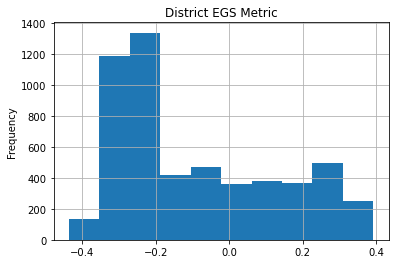

In [31]:
df_dist_egs['avg_egs'].plot(kind='hist', title='District EGS Metric', grid=True)

In [4]:
df_dist_egs['avg_egs'].describe()

count    5400.000000
mean       -0.089609
std         0.217358
min        -0.435704
25%        -0.268870
50%        -0.182515
75%         0.100093
max         0.391925
Name: avg_egs, dtype: float64

In [5]:
# set low and high bound for thresholds - 1 std deviation away from mean either direction
low_bound = df_dist_egs['avg_egs'].mean() - (df_dist_egs['avg_egs'].std())
up_bound = (df_dist_egs['avg_egs'].std()) + df_dist_egs['avg_egs'].mean()

In [6]:
# create label column using the thresholds
df_dist_egs['label'] = pd.cut(df_dist_egs['avg_egs'], [-1, low_bound, up_bound, 1], labels=[True, False, True], ordered=False)

In [7]:
# value counts of labels
df_dist_egs['label'].value_counts()

False    3545
True     1855
Name: label, dtype: int64

In [47]:
# generating the multiclass labels
df_dist_egs['category'] = pd.cut(df_dist_egs['avg_egs'], [-1, low_bound, -0.1, 0.1, up_bound, 1], 
labels=['high', 'medium', 'low', 'medium', 'high'], ordered=False)

df_dist_egs['category'].value_counts()

medium    2585
high      1855
low        960
Name: category, dtype: int64

In [9]:
# creating timestep and district columns to eventually match the observation with its image
tlist = len(demo_cols)*[str(val) for val in np.arange(start=1, stop=steps+1)]
tlist = [int(x) for x in tlist]
tlist.sort()
df_compacts['timestep'] = tlist
df_compacts['district'] = steps*demo_cols
df_compacts

,pols_value,reock_value,schwartz_value,bpop,tpop,wpop,area,timestep,district
0,0.364742,0.438936,0.603939,33051,701954,668903,0.937697,1,d14
1,0.168254,0.324483,0.410187,17295,713362,696067,1.650288,1,d13
2,0.229826,0.389075,0.479402,16752,701020,684268,2.676980,1,d10
3,0.269912,0.540076,0.519531,13091,697040,683949,2.738327,1,d11
4,0.150695,0.357023,0.388194,17167,711018,693851,0.832887,1,d18
...,...,...,...,...,...,...,...,...,...
5395,0.101058,0.321847,0.317896,54753,691530,636777,0.636230,300,d15
5396,0.227755,0.487144,0.477237,239968,695541,455573,0.023201,300,d6
5397,0.248055,0.307518,0.498051,231901,717199,485298,0.045847,300,d16
5398,0.198399,0.392052,0.445420,32160,705491,673331,0.157096,300,d2


In [10]:
# generating image_file column from timestep and district columns to match image with dataframe row
df_compacts['image_file'] = ['plot' + str(x) + y + '.png' for x,y in zip(df_compacts['timestep'], df_compacts['district'])]
df_compacts

,pols_value,reock_value,schwartz_value,bpop,tpop,wpop,area,timestep,district,image_file
0,0.364742,0.438936,0.603939,33051,701954,668903,0.937697,1,d14,plot1d14.png
1,0.168254,0.324483,0.410187,17295,713362,696067,1.650288,1,d13,plot1d13.png
2,0.229826,0.389075,0.479402,16752,701020,684268,2.676980,1,d10,plot1d10.png
3,0.269912,0.540076,0.519531,13091,697040,683949,2.738327,1,d11,plot1d11.png
4,0.150695,0.357023,0.388194,17167,711018,693851,0.832887,1,d18,plot1d18.png
...,...,...,...,...,...,...,...,...,...,...
5395,0.101058,0.321847,0.317896,54753,691530,636777,0.636230,300,d15,plot300d15.png
5396,0.227755,0.487144,0.477237,239968,695541,455573,0.023201,300,d6,plot300d6.png
5397,0.248055,0.307518,0.498051,231901,717199,485298,0.045847,300,d16,plot300d16.png
5398,0.198399,0.392052,0.445420,32160,705491,673331,0.157096,300,d2,plot300d2.png


### Visualize and Label Compactness Metrics

<AxesSubplot:>

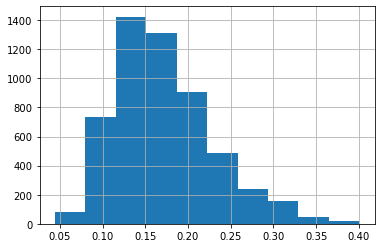

In [11]:
# Polsby-Popper
df_compacts['pols_value'].hist()

<AxesSubplot:>

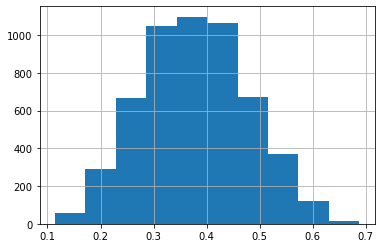

In [12]:
# Reock
df_compacts['reock_value'].hist()

<AxesSubplot:>

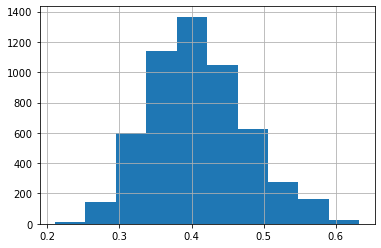

In [13]:
# Schwartzberg
df_compacts['schwartz_value'].hist()

In [14]:
# average the 3 compactness metrics
df_compacts['avg_value'] = df_compacts[df_compacts.columns[:3]].mean(axis=1)

<AxesSubplot:title={'center':'Average District Compactness'}, ylabel='Frequency'>

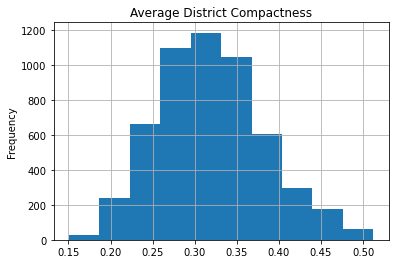

In [30]:
# histogram of average
df_compacts['avg_value'].plot(kind='hist', title='Average District Compactness', grid=True)

In [51]:
df_compacts['avg_value'].mean()

0.3196478246194614

In [52]:
# set compactness label with mean threshold
df_compacts['label'] = np.where(df_compacts['avg_value'] < df_compacts['avg_value'].mean(), True, False)
df_compacts

,pols_value,reock_value,schwartz_value,bpop,tpop,wpop,area,timestep,district,image_file,avg_value,label,egs_label,category
0,0.364742,0.438936,0.603939,33051,701954,668903,0.937697,1,d14,plot1d14.png,0.469205,False,False,medium
1,0.168254,0.324483,0.410187,17295,713362,696067,1.650288,1,d13,plot1d13.png,0.300975,True,False,medium
2,0.229826,0.389075,0.479402,16752,701020,684268,2.676980,1,d10,plot1d10.png,0.366101,False,False,medium
3,0.269912,0.540076,0.519531,13091,697040,683949,2.738327,1,d11,plot1d11.png,0.443173,False,False,medium
4,0.150695,0.357023,0.388194,17167,711018,693851,0.832887,1,d18,plot1d18.png,0.298637,True,False,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,0.101058,0.321847,0.317896,54753,691530,636777,0.636230,300,d15,plot300d15.png,0.246934,True,True,high
5396,0.227755,0.487144,0.477237,239968,695541,455573,0.023201,300,d6,plot300d6.png,0.397379,False,False,low
5397,0.248055,0.307518,0.498051,231901,717199,485298,0.045847,300,d16,plot300d16.png,0.351208,False,True,high
5398,0.198399,0.392052,0.445420,32160,705491,673331,0.157096,300,d2,plot300d2.png,0.345290,False,True,high


In [17]:
# compactness label value counts
df_compacts['label'].value_counts()

True     2850
False    2550
Name: label, dtype: int64

In [48]:
df_compacts['egs_label'] = df_dist_egs['label']
df_compacts['category'] = df_dist_egs['category']

In [49]:
df_compacts

,pols_value,reock_value,schwartz_value,bpop,tpop,wpop,area,timestep,district,image_file,avg_value,label,egs_label,category
0,0.364742,0.438936,0.603939,33051,701954,668903,0.937697,1,d14,plot1d14.png,0.469205,False,False,medium
1,0.168254,0.324483,0.410187,17295,713362,696067,1.650288,1,d13,plot1d13.png,0.300975,True,False,medium
2,0.229826,0.389075,0.479402,16752,701020,684268,2.676980,1,d10,plot1d10.png,0.366101,False,False,medium
3,0.269912,0.540076,0.519531,13091,697040,683949,2.738327,1,d11,plot1d11.png,0.443173,False,False,medium
4,0.150695,0.357023,0.388194,17167,711018,693851,0.832887,1,d18,plot1d18.png,0.298637,True,False,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,0.101058,0.321847,0.317896,54753,691530,636777,0.636230,300,d15,plot300d15.png,0.246934,True,True,high
5396,0.227755,0.487144,0.477237,239968,695541,455573,0.023201,300,d6,plot300d6.png,0.397379,False,False,low
5397,0.248055,0.307518,0.498051,231901,717199,485298,0.045847,300,d16,plot300d16.png,0.351208,False,True,high
5398,0.198399,0.392052,0.445420,32160,705491,673331,0.157096,300,d2,plot300d2.png,0.345290,False,True,high


### Save Dataframes, Train-Test-Split, Move Images

In [50]:
df_cats = df_compacts[['image_file', 'category']]
df_cats.to_csv('Outputs/categories_blue.csv')

In [53]:
df_compacts.to_csv('Outputs/cleaned_dist_data_blue_run.csv')

In [22]:
# Set metric label to use
labs = ['egs_label', 'label']

# train-test split
train_master, test_master = train_test_split(df_compacts, test_size=0.2)

# validation data
train_master, val_master = train_test_split(train_master, test_size=0.1)

In [26]:
# move the district images to their respective folders (train, test, validation)

cat_labels = ['train', 'test', 'val']
color = 'blue'

for lbl in cat_labels:
    
    if lbl == 'train':

        for i in train_master['image_file']:
            os.replace(f'Outputs/images/{color}/{i}', f'Outputs/images/{color}/train/{i}')

    elif lbl == 'test':
        
        for i in test_master['image_file']:
            os.replace(f'Outputs/images/{color}/{i}', f'Outputs/images/{color}/test/{i}')
    
    else:

        for i in val_master['image_file']:
            os.replace(f'Outputs/images/{color}/{i}', f'Outputs/images/{color}/val/{i}')

In [27]:
# save demographic data to csv

for l in labs:
    dem_cols = ['tpop', 'bpop', 'wpop', 'area', l, 'image_file']

    train_master[dem_cols].to_csv(dir_path+f'{color}_train_data_{l}.csv')
    test_master[dem_cols].to_csv(dir_path+f'{color}_test_data_{l}.csv')
    val_master[dem_cols].to_csv(dir_path+f'{color}_val_data_{l}.csv')

In [28]:
# copy images into True/False subfolders - required to use Keras ImageDataGenerators

cat_labels = ['train', 'test', 'val']

for lbl in cat_labels:

    if lbl == 'train':

        true_images = list(train_master.loc[train_master['label'] == True, 'image_file']) 
        false_images = list(train_master.loc[train_master['label'] == False, 'image_file'])

        for i in true_images:
            shutil.copy(f'Outputs/images/{color}/train/{i}', f'Outputs/images/{color}/train/sub/true/{i}')
        
        for i in false_images:
            shutil.copy(f'Outputs/images/{color}/train/{i}', f'Outputs/images/{color}/train/sub/false/{i}')


    elif lbl == 'test':

        true_images = list(test_master.loc[test_master['label'] == True, 'image_file'])
        false_images = list(test_master.loc[test_master['label'] == False, 'image_file'])

        for i in true_images:
            shutil.copy(f'Outputs/images/{color}/test/{i}', f'Outputs/images/{color}/test/sub/true/{i}')
        
        for i in false_images:
            shutil.copy(f'Outputs/images/{color}/test/{i}', f'Outputs/images/{color}/test/sub/false/{i}')
        
    
    else:
        
        true_images = list(val_master.loc[val_master['label'] == True, 'image_file']) 
        false_images = list(val_master.loc[val_master['label'] == False, 'image_file'])

        for i in true_images:
            shutil.copy(f'Outputs/images/{color}/val/{i}', f'Outputs/images/{color}/val/sub/true/{i}')
        
        for i in false_images:
            shutil.copy(f'Outputs/images/{color}/val/{i}', f'Outputs/images/{color}/val/sub/false/{i}')